## Beta distribution shit

In [1]:
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm

device = 'cuda'
batch_size = 64

In [2]:
T = 1000
import numpy as np

def log_beta_fn(z_1, z_2):
    return torch.special.gammaln(z_1) + torch.special.gammaln(z_2) - torch.special.gammaln(z_1 + z_2)

def alpha_beta(mu, x_0):
    return 1 + mu.reshape([-1, 1, 1, 1]) * x_0, 1 + mu.reshape([-1, 1, 1, 1]) * (1 - x_0)

def KL(x_0, x_theta, t):
    mu = noising_sch(t).reshape([-1, 1, 1, 1]) 
    alpha_0, beta_0 = alpha_beta(mu, x_0)
    alpha_theta, beta_theta = alpha_beta(mu, x_theta)
    kl_div = log_beta_fn(alpha_theta, beta_theta)
    kl_div = kl_div - log_beta_fn(alpha_0, beta_0)
    kl_div = kl_div + mu * (x_0 - x_theta) * ((torch.special.digamma(alpha_0) - torch.special.digamma(beta_0)))
    return kl_div

def sufficient_stats(x_t, t):
    theta = noising_sch(t).reshape([-1, 1, 1, 1])
    
    return theta * torch.log(x_t / (1 - x_t))
                                                 
def noising_sch(t, mode='exp_linear', theta_start=1e4, theta_end = 1e-3):
    if mode == 'linear':
        theta = theta_end + (T - t) / T * (theta_start - theta_end)
    elif mode=='exp_linear':
        log10_theta = np.log10(theta_end) + (T - t) / T * (np.log10(theta_start) - np.log10(theta_end))
        theta = torch.pow(10, log10_theta)
    else:
        raise BaseException('Unknown schedule mode')
        
    return torch.Tensor(theta).to(device)

## Training

In [3]:
from tqdm.notebook import tqdm
from torch.distributions.beta import Beta
import torch
import time

def sample_t_batch(batch_size):
    
    cat_dist = torch.distributions.categorical.Categorical(1 / T * torch.ones([T]))
    
    t_batch = cat_dist.sample([batch_size]).to(device) + 1
    
    return t_batch

def sample_chain(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    for s in range(T, int(t_min), -1):
        helper_slice = helper[:, s]
        
        theta = noising_sch(t_batch)
        
        alpha, beta = alpha_beta(theta, x_0)
        
        dist = Beta(alpha, beta)
        samples.append(dist.sample())
        s_batch = torch.tensor([s], device=device).repeat(batch_size)

        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
    return samples, suff_stats

def train_sample_online(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    
    for i in pbar:
        x_0 = next(iter(dataloader))[0].to(device)
        t_batch = sample_t_batch(batch_size)
        
        start = time.time()
        
        noised_samples, suff_stats = sample_chain(t_batch, x_0)
        
        end = time.time()
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item()} Time for sample chain {end - start} s')
        if (i + 1) % 100 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item()}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')
        
def generate(model):
    model.eval()
    x_t = torch.rand([batch_size, 1, 28, 28]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    for t in tqdm(range(T + 1, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats, t_batch)
        
        mu = noising_sch(t_batch)
        
        alpha, beta = alpha_beta(mu, x_0)
        
        dist = Beta(alpha, beta)
        x_t = dist.sample()
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))
        
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats, t_batch)
    
    return x_0

In [8]:
torch.set_printoptions(threshold=10000)

data_sample = next(iter(dataloader))[0].to(device)

t_batch = sample_t_batch(batch_size)
samples, suff_stats = sample_chain(t_batch, data_sample)
suff_stats;

In [6]:
dist = Beta(0.5 * torch.ones([100]), 0.5 * torch.ones([100]))

beta_samples = dist.sample()
print(beta_samples.shape)

torch.Size([100])


## Data

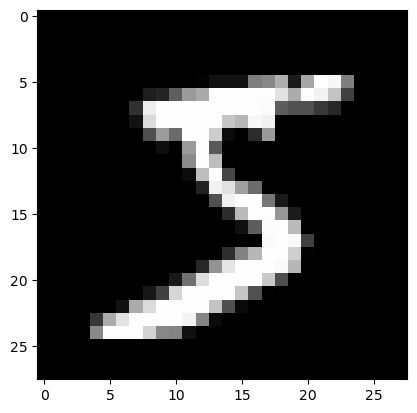

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np

dataset = MNIST(root='MNIST', download=True,transform=transforms.Compose([transforms.ToTensor()]))

import matplotlib.pyplot as plt

plt.imshow(dataset[0][0].squeeze(), cmap='gray')

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
class ForwardDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor
        
    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
def load_generated_dataset():
    x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('x_0_dataset.pth'), torch.load('t_batch_dataset.pth'), torch.load('suff_stats_dataset.pth')
    return ForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataset = load_generated_dataset()

forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=batch_size, shuffle=True)

## Model

In [7]:
# steal the model from https://github.com/abarankab/DDPM

%cd ../DDPM
from ddpm.unet import UNet
%cd ../ssddpm

/mounted/DDPM
/mounted/ssddpm


In [8]:
import torch.nn.functional as F
device = 'cuda'
model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

class BetaUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = UNet(1, 32, (1, 2, 4), time_emb_dim=16)

    def forward(self, x_t, t):
        return F.sigmoid(self.model(x_t, t))

model = BetaUnet()
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:

train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]

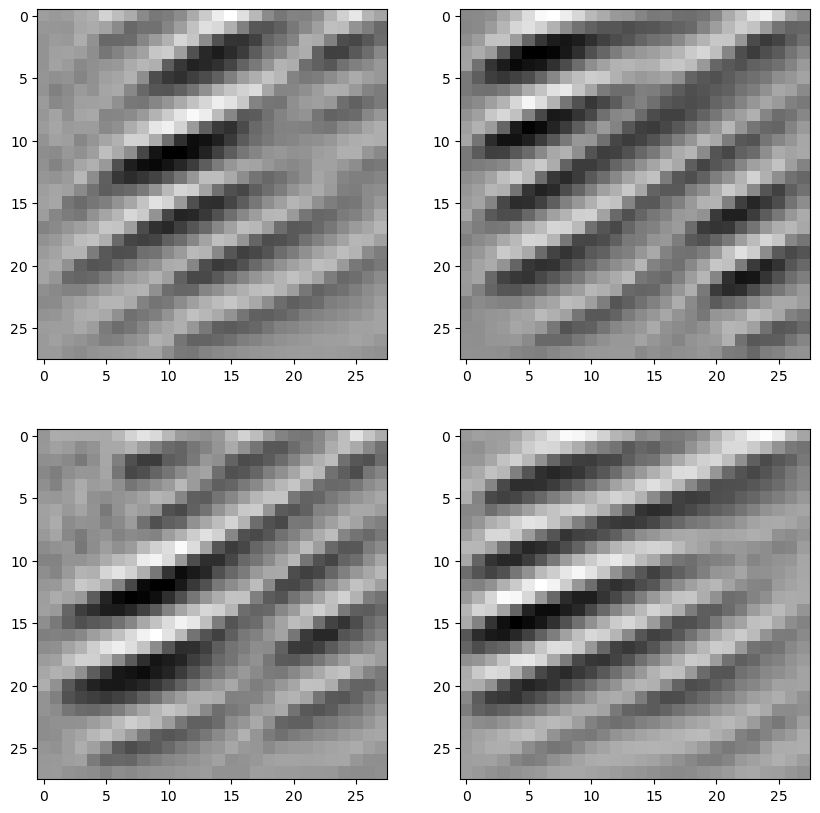

In [12]:
samples = generate(model)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].imshow(samples[0].detach().cpu().numpy().squeeze(), cmap='gray')
axes[0][1].imshow(samples[1].detach().cpu().numpy().squeeze(), cmap='gray')
axes[1][0].imshow(samples[2].detach().cpu().numpy().squeeze(), cmap='gray')
axes[1][1].imshow(samples[3].detach().cpu().numpy().squeeze(), cmap='gray')